# Capstone London - Coursera Assignment #
### <font color=grey>Analysis of London for establishing a Vegan takeaway/delivery restaurant</font>  ###


This notebook analyses Greater London to first identify the optimal borough in which to establish a Vegan takeaway business and then identify suitable locations


In [3]:
# import the required packages

#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import itertools
import numpy as np
import pandas as pd
import types
import os
import json
import requests
import ibm_boto3
import matplotlib.pyplot as plt
import matplotlib.pylab as pyplt
import seaborn as sns
import matplotlib.ticker as ticker
from botocore.client import Config
from sklearn import preprocessing
from folium.features import DivIcon
from branca.utilities import split_six
from sklearn.cluster import KMeans

%matplotlib inline

Initial research has identified the target demography for our restaurant to be people aged 18 - 34 (research by Waitrose food group, published by The Guardian newspaper https://www.theguardian.com/business/2018/nov/01/third-of-britons-have-stopped-or-reduced-meat-eating-vegan-vegetarian-report)


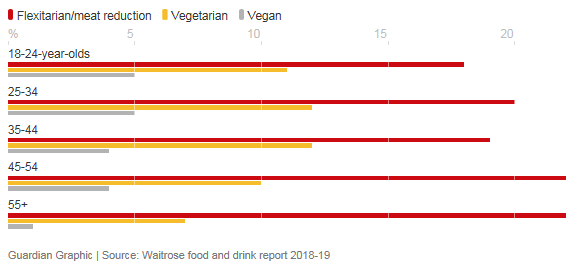


Mango Map provides useful demographic data on London (https://mangomap.com/demographics/maps)

Download data from MangoMap on number of residents by age group

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# Read 'age__population_and_households.csv' from the MangoMap site (copied into Watson cloud storage)

age_df = pd.read_csv(body)
age_df.head()

,Y,X,lsoa11cd,lsoa11nm,msoa11cd,msoa11nm,lad11cd,lad11nm,rgn11cd,rgn11nm,...,a_h_w_chil,a_h_wo_chi,a_sing_par,a_h_w_one,a_h_other,a_h_w_ch_1,a_h_wo_c_1,a_sin_parp,a_h_w_onep,a_h_other_
0,NaN,NaN,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,...,67,268,23,453,65,7.6,30.6,2.6,51.7,7.4
1,NaN,NaN,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,...,86,255,22,418,49,10.4,30.7,2.7,50.4,5.9
2,NaN,NaN,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,...,51,156,49,507,54,6.2,19.1,6.0,62.1,6.6
3,NaN,NaN,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,...,61,67,44,228,67,13.1,14.3,9.4,48.8,14.3
4,NaN,NaN,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,...,139,118,54,97,135,25.6,21.7,9.9,17.9,24.9


In [6]:
age_df.dtypes

Y             float64
X             float64
lsoa11cd       object
lsoa11nm       object
msoa11cd       object
msoa11nm       object
lad11cd        object
lad11nm        object
rgn11cd        object
rgn11nm        object
usualres        int64
hholdres        int64
comestres       int64
popden        float64
hholds          int64
avhholdsz     float64
a_pop           int64
a_p0_15         int64
a_p16_29        int64
a_p30_44        int64
a_p45_64        int64
a_p65o          int64
a_working_      int64
a_area_h      float64
a_peo_per_      int64
a_househ        int64
a_h_w_chil      int64
a_h_wo_chi      int64
a_sing_par      int64
a_h_w_one       int64
a_h_other       int64
a_h_w_ch_1    float64
a_h_wo_c_1    float64
a_sin_parp    float64
a_h_w_onep    float64
a_h_other_    float64
dtype: object

We will use the age 16-29 category, as it is close our 18-34 grouping

*Lets see which boroughs have the largest 16-29 populations* 

Text(0, 0.5, 'Borough')

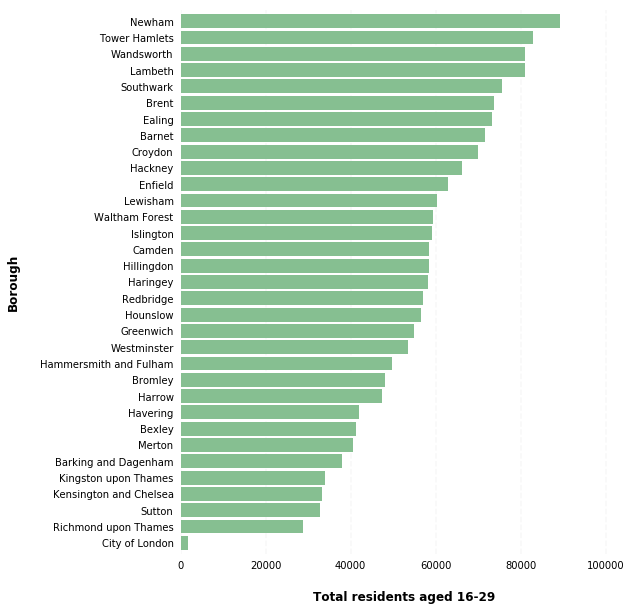

In [7]:
young_df_summary = age_df.groupby('lad11nm')['a_p16_29'].sum().sort_values()
young_df_summary = young_df_summary.rename(columns = {'lad11nm':'Borough','a_p16_29':'Young pop'})

ax = young_df_summary.plot(kind='barh', figsize=(8,10), color='#86bf91', zorder=2, width=0.85)

# despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Total residents aged 16-29", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Borough", labelpad=20, weight='bold', size=12)


Next we need some assessment of spending for each borough

### Gross disposable household income (GDHI) per head for NUTS3 local areas, UK, 1997 to 2017 ###
Download data from UK Office for National Statistics

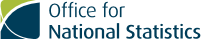

In [8]:
# Read data_map.csv from the UK ONS site (copied into Watson cloud storage)
# source: https://www.ons.gov.uk/economy/regionalaccounts/grossdisposablehouseholdincome/bulletins/regionalgrossdisposablehouseholdincomegdhi/1997to2016

body = client_b5b6e148ab014e0fa8f515cd6dac860b.get_object(Bucket='capstone-donotdelete-pr-w7zwxiwhckvlhw',Key='data_map.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
income_df = pd.read_csv(body)
income_df.head()

,AREANM,AREACD,1997,1998,1999,2000,2001,2002,2003,2004,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Hartlepool and Stockton-on-Tees,UKC11,9245,9332,9714,10238,10677,11026,11263,11704,...,13206,13708,13842,14202,14702,14717,15097,15498,15432,15782
1,South Teesside,UKC12,8961,8768,9146,9771,10239,10318,10496,10874,...,12120,12860,12846,13099,13956,14083,14572,14959,14835,14955
2,Darlington,UKC13,9612,9626,9699,10634,11483,11588,11873,12131,...,13178,13840,13757,13655,14306,14691,14828,15486,15916,15953
3,Durham CC,UKC14,9219,9547,9831,10423,10821,10997,11170,11709,...,12737,13193,13474,13610,14130,14391,14697,15276,15166,15445
4,Northumberland,UKC21,10279,10534,10957,11766,12219,12455,12973,13379,...,15630,16573,16404,16552,17238,17623,17810,18463,18498,18855


Merge the household income with the Young Population dataframe by Borough

In [9]:
#align column names for both dataframes
income_df_summary = income_df[['AREANM','2017']].rename(columns = {'AREANM':'Borough','2017':'HH Income'})
young_df_summ = young_df_summary.to_frame().reset_index().rename(columns = {'lad11nm':'Borough',0:'YoungPop'})

#merge the data
pd.merge(young_df_summ,income_df_summary, on='Borough', how='left')

,Borough,YoungPop,HH Income
0,City of London,1665,NaN
1,Richmond upon Thames,28810,NaN
2,Sutton,32859,NaN
3,Kensington and Chelsea,33262,NaN
4,Kingston upon Thames,33928,NaN
5,Barking and Dagenham,38075,NaN
6,Merton,40596,NaN
7,Bexley,41350,NaN
8,Havering,41864,NaN
9,Harrow,47384,NaN


A number of Boroughs have NaN for Household Income, as the dataset grouped certain Boroughs. Need to find a better dataset!

Lets use a dataset of household expenditure from the London government's Datastore (https://data.london.gov.uk/dataset/london-consumer-expenditure-estimates-2011-2036)

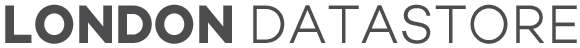

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


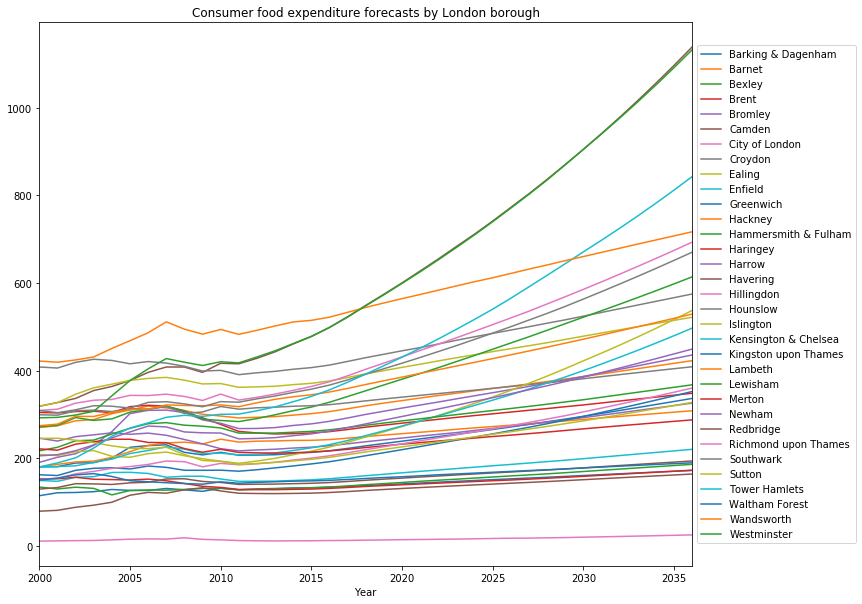

In [11]:
# Read detailed-borough-base.xls from the Datastore (copied into Watson cloud storage)

body = client_b5b6e148ab014e0fa8f515cd6dac860b.get_object(Bucket='capstone-donotdelete-pr-w7zwxiwhckvlhw',Key='detailed-borough-base.xls')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
expenditure_df = pd.read_excel(body,"Greater London")

#clean up the table
expenditure_df.columns=expenditure_df.iloc[1]
expenditure_df.drop(expenditure_df.index[[0,1,2]],inplace=True)

#lets just look at Food expenditure for now
exp_food_df = expenditure_df.loc[expenditure_df['Sector'] == 'Food'].set_index('Local Authority').drop(expenditure_df.columns[[1,2]],axis=1).drop(['Greater London'])

#The data is several years old, but includes projections out to 2036
#we will plot a line chart to see if the boroughs show a similar trend

exp_food_df.T.plot(figsize=(18,10))  #legend=True
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.title('Consumer food expenditure forecasts by London borough')
plt.xlabel('Year')
plt.show()

We will pull out the projected 2019 numbers and the projected growth rates for all sectors

In [13]:
#calculate growth projection
expenditure_df['10yr Growth projection %']=expenditure_df[2029.0]/expenditure_df[2019.0]*100-100
exp_df_summ=expenditure_df[['Local Authority','Sector',2019.0,'10yr Growth projection %']].reset_index().rename(columns={'Local Authority':'Borough',2019.0:'2019 Expenditure (£ m)'}).drop("index",axis=1)
exp_df_summ.head(100)

1,Borough,Sector,2019 Expenditure (£ m),10yr Growth projection %
0,Barking & Dagenham,Food,139.459832,13.632997
1,Barnet,Food,325.729451,16.839942
2,Bexley,Food,142.054816,17.470357
3,Brent,Food,275.468368,15.245147
4,Bromley,Food,307.162455,23.295505
5,Camden,Food,574.056731,51.546955
6,City of London,Food,13.486068,39.832934
7,Croydon,Food,437.154123,17.975981
8,Ealing,Food,399.896784,17.767497
9,Enfield,Food,163.320337,19.641481


Lets see what sectors are included

In [14]:
exp_df_summ['Sector'].unique().tolist()

['Food',
 nan,
 'Non-alcoholic beverages',
 'Alcoholic beverages',
 'Tobacco',
 'Clothing and footwear\xa0\xa0\xa0\xa0\xa0\xa0 ',
 'Actual rentals for housing\xa0\xa0\xa0\xa0\xa0 ',
 'Imputed rentals for housing\xa0\xa0\xa0\xa0\xa0 ',
 'Maintenance and repair of the dwelling\xa0\xa0\xa0 ',
 'Water supply and miscellaneous services relating to the\xa0 ',
 'Electricity, gas & other fuels\xa0 ',
 'Furniture & Textiles',
 'Household Goods and Services',
 'Medical Products',
 'Medical Services',
 'Purchase of vehicles\xa0\xa0\xa0\xa0\xa0\xa0 ',
 'Operation of personal transport equipment\xa0\xa0\xa0\xa0 ',
 'Transport services\xa0\xa0\xa0\xa0\xa0\xa0\xa0 ',
 'Postal services\xa0\xa0\xa0\xa0\xa0\xa0\xa0 ',
 'Telecommunications Services',
 'Audio-visual\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 ',
 'Other major durables for recreation and culture\xa0\xa0 ',
 'Other recreational items and equipment\xa0\xa0\xa0\xa0 ',
 'Recreational and cultural services\xa0\xa0\xa0\xa0\xa0 ',
 'Newspapers\xa0\xa0\xa0\xa

Sector names need cleaning up

In [15]:
exp_df_summ['Sector']=exp_df_summ['Sector'].replace('\xa0 ','', regex=True)
exp_df_summ['Sector']=exp_df_summ['Sector'].replace('\xa0','', regex=True)
exp_df_summ['Sector'].unique().tolist()

['Food',
 nan,
 'Non-alcoholic beverages',
 'Alcoholic beverages',
 'Tobacco',
 'Clothing and footwear',
 'Actual rentals for housing',
 'Imputed rentals for housing',
 'Maintenance and repair of the dwelling',
 'Water supply and miscellaneous services relating to the',
 'Electricity, gas & other fuels',
 'Furniture & Textiles',
 'Household Goods and Services',
 'Medical Products',
 'Medical Services',
 'Purchase of vehicles',
 'Operation of personal transport equipment',
 'Transport services',
 'Postal services',
 'Telecommunications Services',
 'Audio-visual',
 'Other major durables for recreation and culture',
 'Other recreational items and equipment',
 'Recreational and cultural services',
 'Newspapers',
 'Education',
 'Restaurants and hotels',
 'Personal care',
 'Personal effects n.e.c.',
 'Social protection',
 'Insurance',
 'Other services n.e.c.',
 'Financial services not elsewhere classified']

We will focus on 'Food' and 'Restaurants and hotels'

In [16]:
# extract the two sector categories
exp_by_sect_df=pd.merge(exp_df_summ.loc[exp_df_summ['Sector']=='Food'].drop(['Sector'],axis=1),exp_df_summ.loc[exp_df_summ['Sector']=='Restaurants and hotels'].drop(['Sector'],axis=1), on='Borough', how='left')

#clean up column names
exp_by_sect_df.rename(columns={'2019 Expenditure (£ m)_x':'Food expense 2019 (£m)','2019 Expenditure (£ m)_y':'Restaurant/hotel expense 2019 (£m)','10yr Growth projection %_x':'Food expense 10-year growth %','10yr Growth projection %_y':'Restaurant/hotel expense 10-year growth %'},inplace=True)

exp_by_sect_df.head(10)

1,Borough,Food expense 2019 (£m),Food expense 10-year growth %,Restaurant/hotel expense 2019 (£m),Restaurant/hotel expense 10-year growth %
0,Barking & Dagenham,139.459832,13.632997,150.136859,10.961922
1,Barnet,325.729451,16.839942,536.230612,11.694674
2,Bexley,142.054816,17.470357,173.469754,12.230595
3,Brent,275.468368,15.245147,359.809723,11.087088
4,Bromley,307.162455,23.295505,458.088407,17.730780
5,Camden,574.056731,51.546955,1016.272700,46.945783
6,City of London,13.486068,39.832934,26.132142,34.380094
7,Croydon,437.154123,17.975981,595.948704,13.268300
8,Ealing,399.896784,17.767497,574.191507,13.393355
9,Enfield,163.320337,19.641481,220.197287,15.041605


Now we can add the Young Population statistic

In [17]:
#We first need to align the Borough labelling (the Young Pop dataframe uses 'and' rather than '&')
exp_by_sect_df['Borough']=exp_by_sect_df['Borough'].replace('&','and', regex=True)

#Now we can merge the data
combined_df=pd.merge(exp_by_sect_df,young_df_summ, on='Borough', how='left')
combined_df.head(35)

,Borough,Food expense 2019 (£m),Food expense 10-year growth %,Restaurant/hotel expense 2019 (£m),Restaurant/hotel expense 10-year growth %,YoungPop
0,Barking and Dagenham,139.459832,13.632997,150.136859,10.961922,38075.0
1,Barnet,325.729451,16.839942,536.230612,11.694674,71568.0
2,Bexley,142.054816,17.470357,173.469754,12.230595,41350.0
3,Brent,275.468368,15.245147,359.809723,11.087088,73764.0
4,Bromley,307.162455,23.295505,458.088407,17.730780,48100.0
5,Camden,574.056731,51.546955,1016.272700,46.945783,58504.0
6,City of London,13.486068,39.832934,26.132142,34.380094,1665.0
7,Croydon,437.154123,17.975981,595.948704,13.268300,69937.0
8,Ealing,399.896784,17.767497,574.191507,13.393355,73200.0
9,Enfield,163.320337,19.641481,220.197287,15.041605,62941.0


We will plot this on a Bubble chart to get a feel for which Boroughs are most interesting for our restaurant business

*We will also average the 'Food' and the 'Restaurants & Hotels' data, as we are interested in takeaway food, which sits in the middle of these*

In [18]:
#create new averaged category
combined_df['Proxy target expend (£m)']=(combined_df['Food expense 2019 (£m)']+combined_df['Restaurant/hotel expense 2019 (£m)'])/2
combined_df['Proxy target growth (%)']=(combined_df['Food expense 10-year growth %']+combined_df['Restaurant/hotel expense 10-year growth %'])/2

#remove the total row
combined_df=combined_df[exp_by_sect_df.Borough != 'Greater London']
combined_df.head(35)

,Borough,Food expense 2019 (£m),Food expense 10-year growth %,Restaurant/hotel expense 2019 (£m),Restaurant/hotel expense 10-year growth %,YoungPop,Proxy target expend (£m),Proxy target growth (%)
0,Barking and Dagenham,139.459832,13.632997,150.136859,10.961922,38075.0,144.798345,12.297460
1,Barnet,325.729451,16.839942,536.230612,11.694674,71568.0,430.980031,14.267308
2,Bexley,142.054816,17.470357,173.469754,12.230595,41350.0,157.762285,14.850476
3,Brent,275.468368,15.245147,359.809723,11.087088,73764.0,317.639045,13.166117
4,Bromley,307.162455,23.295505,458.088407,17.730780,48100.0,382.625431,20.513142
5,Camden,574.056731,51.546955,1016.272700,46.945783,58504.0,795.164715,49.246369
6,City of London,13.486068,39.832934,26.132142,34.380094,1665.0,19.809105,37.106514
7,Croydon,437.154123,17.975981,595.948704,13.268300,69937.0,516.551413,15.622141
8,Ealing,399.896784,17.767497,574.191507,13.393355,73200.0,487.044145,15.580426
9,Enfield,163.320337,19.641481,220.197287,15.041605,62941.0,191.758812,17.341543


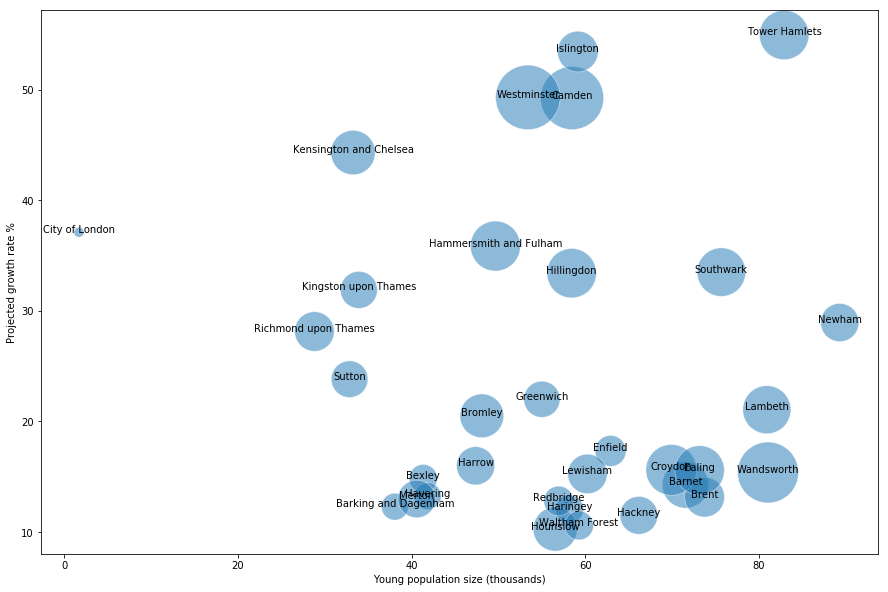

In [19]:
#plot bubble chart

x=combined_df['YoungPop']/1000
y=combined_df['Proxy target growth (%)']
z=combined_df['Proxy target expend (£m)']*5
labels=combined_df['Borough']
colors=combined_df.index

pyplt.figure(figsize = (15,10))
ax = sns.scatterplot(x, y, s=z, alpha = 0.5)
ax.set_xlabel('Young population size (thousands)')
ax.set_ylabel('Projected growth rate %')

#For each point, we add a text inside the bubble
for line in range(0,combined_df.shape[0]):
     ax.text(x[line], y[line], labels[line], horizontalalignment='center', size='medium', color='black') 

Based on the analysis, I will select Westminster and Camden as the two boroughs to pursue, as they bother have a large young population (over 50,000), high growth prospects (around 50% over the next 10 years) and large current household expenditure on food/restaurants (around £800m forecast for in 2019). 

## Mapping London ##


First, we will visualise growth projections for London boroughs, using the GeoData geojson file from the UK Office for National Statistics Open Geography Portal

(https://geoportal.statistics.gov.uk/datasets/local-authority-districts-april-2019-boundaries-uk-buc)

In [20]:
state_geo = 'https://opendata.arcgis.com/datasets/bbb0e58b0be64cc1a1460aa69e33678f_0.geojson'

m = folium.Map(location=[51.5, -0.15], zoom_start=10)
m.choropleth(
    geo_data=state_geo,
    data=combined_df,
    columns=['Borough', 'Proxy target growth (%)'],
    key_on='feature.properties.lad19nm',  #PCPCON17NM',   #lau16cd',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='Orange',
    line_weight=4,
    legend_name='10 year growth rate %',
    highlight=True
)

folium.map.Marker(
    [51.55,-0.163],
    icon=DivIcon(
        icon_size=(50,36),
        icon_anchor=(25,18),
        html='<div style="font-size: 9pt; color: red">Camden</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [51.51,-0.16],
    icon=DivIcon(
        icon_size=(70,36),
        icon_anchor=(35,18),
        html='<div style="font-size: 9pt; color: red">Westminster</div>',
        )
    ).add_to(m)

m

**Next we hone in on Camden and Westminster, and analyse expenditure at a local level, before locating existing vegan restaurants**

First, let's zoom in on the boroughs of Westminster and Camden on the choropleth map


In [21]:
m2 = folium.Map(location=[51.53, -0.15], zoom_start=12.5)
m2.choropleth(
    geo_data=state_geo,
    data=combined_df,
    columns=['Borough', 'Proxy target growth (%)'],
    key_on='feature.properties.lad19nm',  
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='Orange',
    line_weight=4,
    legend_name='10 year growth rate %',
    highlight=True
)
m2

The 'London Consumer Expenditure Estimates 2011-2036' datasets on the London Datastore site includes projections by postcode for Greater London, including a sector for takeaways and snacks in a spreadsheet with worksheets for each borough.

We will read in the 2019 Takeaway date for Camden and Westminster and combine to get expenditure for each postcode. 
This is then illustrated in a histogram.

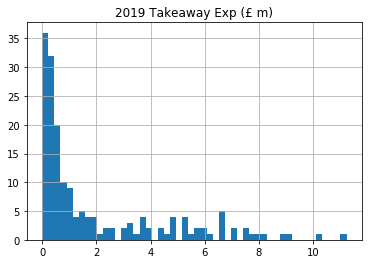

In [22]:
# Read aggregate-postal-base-greater-london.xls from the Datastore (copied into Watson cloud storage)

body = client_b5b6e148ab014e0fa8f515cd6dac860b.get_object(Bucket='capstone-donotdelete-pr-w7zwxiwhckvlhw',Key='aggregated-postal-base-greater-london.xls')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
camden_df = pd.read_excel(body,"Camden")

body = client_b5b6e148ab014e0fa8f515cd6dac860b.get_object(Bucket='capstone-donotdelete-pr-w7zwxiwhckvlhw',Key='aggregated-postal-base-greater-london.xls')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
westminster_df = pd.read_excel(body,"Westminster")

#clean up the tables
camden_df.columns=camden_df.iloc[2]
camden_df.drop(camden_df.index[[0,1,2,3]],inplace=True)
westminster_df.columns=westminster_df.iloc[2]
westminster_df.drop(westminster_df.index[[0,1,2,3]],inplace=True)

#select the 2019 takeaway data from the two dataframes and combine
camden19_df = camden_df[['Postal Code','Sector',2019.0]].loc[camden_df['Sector']=="Takeaway / Snack Spending"].reset_index().rename(columns={'Postal Code':'Postcode',2019.0:'2019 Takeaway Exp (£ m)'}).drop("index",axis=1).drop(['Sector'],axis=1)
westminster19_df = westminster_df[['Postal Code','Sector',2019.0]].loc[westminster_df['Sector']=="Takeaway / Snack Spending"].reset_index().rename(columns={'Postal Code':'Postcode',2019.0:'2019 Takeaway Exp (£ m)'}).drop("index",axis=1).drop(['Sector'],axis=1)
camdwest19_df = camden19_df.append(westminster19_df).reset_index().drop("index",axis=1)

#plot histogram of expenditure by postcode
hist=camdwest19_df.hist(column='2019 Takeaway Exp (£ m)',bins=50)


The histogram shows the vast majority of postcodes spend less than a million. We will focus on those spending at least £5, and plot points on the map for each postcode colored according to Takeaway spend.

In [23]:
floor=5.0
print("Camden and Westminster together have %d postcodes, but only %d spend £%dm or more." % (len(camdwest19_df),(camdwest19_df['2019 Takeaway Exp (£ m)'] >= floor).values.sum(),floor))

Camden and Westminster together have 174 postcodes, but only 26 spend £5m or more.


In [24]:
camdwest19_df.head()

2,Postcode,2019 Takeaway Exp (£ m)
0,EC1M3,0.150362
1,EC1N6,0.000618
2,EC1N7,0.803023
3,EC1N8,0.570774
4,EC1R5,0.400891


First, we need to add longitude/latitude coordinates for the center points of each postcode. We will use the ONS Postcode Directory from Open Postcode Geo, provided on the 'get the data' site (https://www.getthedata.com/open-postcode-geo), which I have uploaded to the IBM cloud.

In [25]:
# Read open_postcode_geo.csv (copied into Watson cloud storage)

body = client_b5b6e148ab014e0fa8f515cd6dac860b.get_object(Bucket='capstone-donotdelete-pr-w7zwxiwhckvlhw',Key='open_postcode_geo.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
postcode_df = pd.read_csv(body,names=["Postcode", "Status", "Usertype", "Easting","Northing","PQI","Country","Latitude","Longitude","PostcodeNS","PC7","PC8","Area","District","Sector","Outcode","Incode"])

#file is very big, so limit it to London postcode 'Areas', and just the relevant columns
areas=['EC','N','NW','W','WC','NW','SW','W']
lon_postcode_df = postcode_df[["Sector","Latitude","Longitude","Area"]].loc[postcode_df['Area'].isin(areas)].drop('Area', axis=1)

#the 'Postcode' level of the table is more granular than we need, so we need to group by Sector, averaging the coordinates
lon_postcode_df['Sector'] = lon_postcode_df['Sector'].str.replace(" ","")
lon_postcode_df=lon_postcode_df[lon_postcode_df['Latitude'] != "\\N"]  #remove rows with no value
lon_postcode_df=lon_postcode_df[lon_postcode_df['Longitude'] != "\\N"]  #remove rows with no value
lon_postcode_df['Latitude'] = lon_postcode_df['Latitude'].astype('float') 
lon_postcode_df['Longitude'] = lon_postcode_df['Longitude'].astype('float') 
lon_postcode_df = lon_postcode_df.groupby(['Sector']).mean()  
lon_postcode_df.index = lon_postcode_df.index.set_names(['Postcode'])

#pull positional data into camdwest19_df
candwest_pc_df=pd.merge(camdwest19_df,lon_postcode_df, on='Postcode', how='left')
candwest_pc_df.head()

,Postcode,2019 Takeaway Exp (£ m),Latitude,Longitude
0,EC1M3,0.150362,51.521129,-0.107445
1,EC1N6,0.000618,51.518867,-0.107598
2,EC1N7,0.803023,51.520733,-0.110733
3,EC1N8,0.570774,51.520619,-0.108745
4,EC1R5,0.400891,51.522533,-0.110597


We will circle the centers of the top 26 postcodes on the map with deeper red shades for higher expenditures

In [26]:
m3 = folium.Map(location=[51.53, -0.15], zoom_start=12.5)
point_layer = folium.FeatureGroup(name="High Exp Postcodes")

for index, row in candwest_pc_df.iterrows():
    if (row['2019 Takeaway Exp (£ m)'] >= 5.0):
        if row['2019 Takeaway Exp (£ m)'] < 7.0:  
            clr = '#ff9f9f'
        elif row['2019 Takeaway Exp (£ m)'] < 9.0:  
            clr = '#ff4f4f'
        else: 
            clr = '#b80000'
        point_layer.add_child(folium.CircleMarker(location=[row['Latitude'],row['Longitude']], radius=10,
        popup=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" , 
        tooltip=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" ,
        fill=True,  # Set fill to True
        color=clr,
        fill_opacity=0.5)).add_to(m3)
        
m3.add_child(point_layer)
m3.add_child(folium.LayerControl())
m3

The higher spending postcodes are around Hamstead/Belsize Park and Bayswater.
As a whole, the £5m+ postcodes seem to be clustered. We can use KNN to confirm this. 

In [27]:
# set number of clusters
kclusters = 5

candwest_pc_clustering = candwest_pc_df.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(candwest_pc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
candwest_pc_df.insert(0, 'Cluster Labels', kmeans.labels_)

#toronto_merged = Toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
candwest_pc_df.head(200)

,Cluster Labels,Postcode,2019 Takeaway Exp (£ m),Latitude,Longitude
0,0,EC1M3,0.150362,51.521129,-0.107445
1,0,EC1N6,0.000618,51.518867,-0.107598
2,0,EC1N7,0.803023,51.520733,-0.110733
3,0,EC1N8,0.570774,51.520619,-0.108745
4,0,EC1R5,0.400891,51.522533,-0.110597
5,0,N1C4,0.004112,51.536228,-0.125727
6,1,N66,3.620494,51.565931,-0.145130
7,1,NW10,3.634475,51.536981,-0.136518
8,3,NW11,2.600682,51.531383,-0.133893
9,0,NW12,0.724253,51.528802,-0.133043


We can plot postcodes over £2m on the map, coloured by cluster

In [28]:
m4 = folium.Map(location=[51.53, -0.15], zoom_start=12.5)
point_layer = folium.FeatureGroup(name="High Exp Postcodes")

for index, row in candwest_pc_df.iterrows():
    if (row['2019 Takeaway Exp (£ m)'] >= 2.0):
        if row['Cluster Labels'] ==4:  
            clr = '#03254c'
        elif row['Cluster Labels'] ==3:  
            clr = '#1167b1'
        elif row['Cluster Labels'] ==2:  
            clr = '#187bcd'
        elif row['Cluster Labels'] ==1:  
            clr = '#2a9df4'
        else: 
            clr = '#d0efff'
        point_layer.add_child(folium.CircleMarker(location=[row['Latitude'],row['Longitude']], radius=10,
        popup=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" , 
        tooltip=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" ,
        fill=True,  # Set fill to True
        color=clr,
        fill_opacity=0.5)).add_to(m4)
        
m4.add_child(point_layer)
m4.add_child(folium.LayerControl())
m4

This shows a similar grouping to the previous map

Finally, we need to plot existing Vegan restaurants from FourSquare on the map.
First, we will pull all the Vegetarian & Vegan venues within 2km of any postcodes with £5m+ spending

In [29]:
# The code was removed by Watson Studio for sharing.

In [30]:
#define function to pull data via the Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORYID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
#Call the Foursquare function for postcodes with expenditure of £5m+

candwest_5m_df=candwest_pc_df.loc[candwest_pc_df['2019 Takeaway Exp (£ m)'] >= 5.0]
camdwest_vegan_venues = getNearbyVenues(names=candwest_5m_df['Postcode'],
                                   latitudes=candwest_5m_df['Latitude'],
                                   longitudes=candwest_5m_df['Longitude'])

camdwest_vegan_venues.head(100)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NW17,51.535875,-0.142984,Purezza,51.538154,-0.144345,Vegetarian / Vegan Restaurant
1,NW17,51.535875,-0.142984,What The Pitta,51.537937,-0.140377,Vegetarian / Vegan Restaurant
2,NW17,51.535875,-0.142984,Dou Dou Restaurant,51.539656,-0.142405,Vegetarian / Vegan Restaurant
3,NW18,51.540880,-0.147668,Mildred's Camden,51.540560,-0.144939,Vegetarian / Vegan Restaurant
4,NW18,51.540880,-0.147668,Young Vegans,51.541454,-0.146686,Vegetarian / Vegan Restaurant
5,NW18,51.540880,-0.147668,Purezza,51.538154,-0.144345,Vegetarian / Vegan Restaurant
6,NW18,51.540880,-0.147668,Hawraman Cafe Bar,51.542902,-0.148172,Café
7,NW18,51.540880,-0.147668,Rudy's Dirty Vegan Diner,51.542488,-0.148512,Vegetarian / Vegan Restaurant
8,NW18,51.540880,-0.147668,Dou Dou Restaurant,51.539656,-0.142405,Vegetarian / Vegan Restaurant
9,NW18,51.540880,-0.147668,Campbell's Canal Café,51.541387,-0.144801,Vegetarian / Vegan Restaurant


Finally, we will plot the existing restaurants as points on the map, alongside the circles showing the high expenditure postcodes

In [32]:
m5 = folium.Map(location=[51.53, -0.15], zoom_start=12.5)
point_layer = folium.FeatureGroup(name="High Exp Postcodes")

for index, row in candwest_pc_df.iterrows():
    if (row['2019 Takeaway Exp (£ m)'] >= 5.0):
        if row['2019 Takeaway Exp (£ m)'] < 7.0:  
            clr = '#ff9f9f'
        elif row['2019 Takeaway Exp (£ m)'] < 9.0:  
            clr = '#ff4f4f'
        else: 
            clr = '#b80000'
        point_layer.add_child(folium.CircleMarker(location=[row['Latitude'],row['Longitude']], radius=10,
        popup=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" , 
        tooltip=str(row['Postcode']) + " Expenditure: £" + str(row['2019 Takeaway Exp (£ m)']) + "m" ,
        fill=True,  # Set fill to True
        color=clr,
        fill_opacity=0.5)).add_to(m5)
        
m5.add_child(point_layer)
#m5.add_child(folium.LayerControl())

vpoint_layer = folium.FeatureGroup(name="Vegetarian & Vegan restaurants")

for index, row in camdwest_vegan_venues.iterrows():
    vpoint_layer.add_child(folium.CircleMarker(location=[row['Venue Latitude'],row['Venue Longitude']], radius=2,
    tooltip=str(row['Venue']),
    fill=True,  # Set fill to True
    color='#1167b1',
    fill_opacity=0.5)).add_to(m5)
        
m5.add_child(vpoint_layer)
m5.add_child(folium.LayerControl())
m5

The map shows that there are numerous Vegetarian/Vegan restaurants around Camden Town and several around the Bayswater area, but little in the Hamstead/Belsize Park area.
>We will therefore advise our client to target Hamstead/Belsize Park for the Vegan delivery restaurant service.